In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import minimize
import cvxpy as cvx
import osqp

In [2]:
import transactive_control.agents as agents

from transactive_control.simulation import Office

ModuleNotFoundError: No module named 'agents'

In [3]:
def price_signal(day = 45):

		"""
		Utkarsha's work on price signal from a building with demand and solar

		Input: Day = an int signifying a 24 hour period. 365 total, all of 2012, start at 1.
		Output: netdemand_price, a measure of how expensive energy is at each time in the day
			optionally, we can return the optimized demand, which is the building
			calculating where the net demand should be allocated
		"""

		pv = np.array([])
		price = np.array([])
		demand = np.array([])

		with open('transactive_control/building_data.csv', encoding='utf8') as csvfile:
		    csvreader = csv.reader(csvfile, delimiter=',')
		    next(csvreader,None)
		    rowcount = 0
		    for row in csvreader:
		        pv = np.append(pv, 0.001*float(row[3])) # Converting Wh to kWh
		        price = np.append(price, float(row[2])) # Cost per kWh
		        val = row[5]
		        if val in (None,""): #How to treat missing values
		            val = 0
		        else:
		            val = float(val) # kWh
		        demand = np.append(demand, val)
		        rowcount+=1
		        # if rowcount>100:
		        #     break

		pvsize = 5 #Assumption

		netdemand = demand.copy()
		for i in range(len(demand)):
		    netdemand[i] = demand[i] - pvsize*pv[i]

		# Data starts at 5 am on Jan 1
		netdemand_24 = netdemand[24*day-5:24*day+19]
		price_24 = price[24*day-5:24*day+19]
		pv_24 = pv[24*day-5:24*day+19]
		demand_24 = demand[24*day-5:24*day+19]

		# Calculate optimal load scheduling. 90% of load is fixed, 10% is controllable.
		def optimise_24h(netdemand_24, price_24):
		    currentcost = netdemand_24*price_24

		    fixed_load = 0.9*netdemand_24
		    controllable_load = sum(0.1*netdemand_24)
		    # fixed_load = 0*netdemand_24
		    # controllable_load = sum(netdemand_24)

		    def objective(x):
		        load = fixed_load + x
		        cost = np.multiply(price_24,load)
		        # Negative demand means zero cost, not negative cost
		        # Adding L1 regularisation to penalise shifting of occupant demand
		        lambd = 0.005
		        return sum(np.maximum(cost,0)) + lambd*sum(abs(x-0.1*netdemand_24))

		    def constraint_sumofx(x):
		        return sum(x) - controllable_load

		    def constraint_x_positive(x):
		        return x

		    x0 = np.zeros(24)
		    cons = [
		        {'type':'eq', 'fun': constraint_sumofx},
		        {'type':'ineq', 'fun':constraint_x_positive}
		    ]
		    sol = minimize(objective, x0, constraints=cons)
		    return sol

		sol = optimise_24h(netdemand_24,price_24)
		x = sol['x']

		netdemand_price_24 = netdemand_24*price_24
        netdemand_price_24 = np.maximum([0.01], netdemand_price_24)
		return(netdemand_price_24)

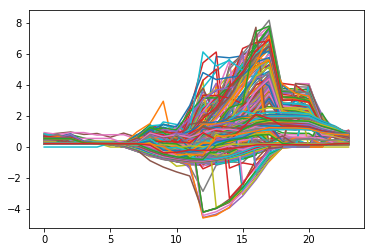

In [45]:
base_price =  price_signal(day=10)
for i in range(1,365):
    price = price_signal(i)[8:18]
    plt.plot(list(range(10)), price_signal(i)[8:18])
    if i == 1:
        prices = price
    else:
        prices = np.vstack([prices, price])

plt.show()

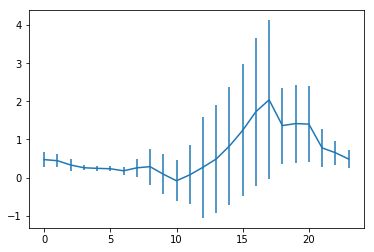

In [5]:
price_mean = np.mean(prices, axis=0)
price_std = np.std(prices, axis=0)
plt.errorbar(list(range(24)), price_mean, price_std)
plt.show()

In [25]:
def ideal_use_calculation(total_demand, min_demand, max_demand, prices):
    """
    Computes an optimization of demand according to price 

    returns: np.array of ideal energy demands given a price signal 
    """

    demands = cvx.Variable(10)

    constraints = [cvx.sum(demands, axis=0, keepdims=True) == total_demand]
    # constraints = [np.ones(self._num_timesteps).T * demands == total_demand]
    for i in range(10):
        constraints += [demands[i] <= max_demand]
        constraints += [min_demand <= demands[i]]


    objective = cvx.Minimize(demands.T * prices)
    problem = cvx.Problem(objective, constraints)

    problem.solve(solver = cvx.OSQP, verbose=False)
    return np.array(demands.value)

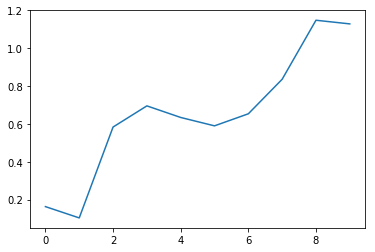

In [44]:
for i in range(1,365):
    ideal = 
    plt.plot(list(range(24)), price_signal(i))
    if i == 1:
        prices = price
    else:
        prices = np.vstack([prices, price])

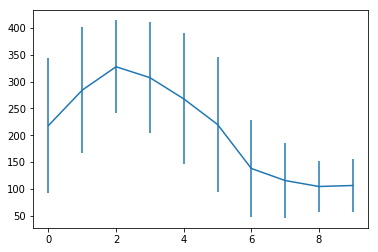

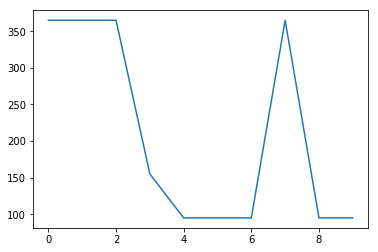

In [46]:
price_mean = np.mean(ideals, axis=0)
price_std = np.std(ideals, axis=0)
plt.errorbar(list(range(10)), price_mean, price_std)
plt.show()
plt.plot(list(range(10)), ideals[71])